# Image classification model

We will start with creating an image classification model which we will later use to build an object detection model. At this stage we will use tensorflow.

Useful links:
https://www.tensorflow.org/tutorials/images/classification,
https://www.youtube.com/watch?v=qFJeN9V1ZsI&ab_channel=freeCodeCamp.org

How to make tensorflow work on m1:

Use the syntax in https://github.com/tensorflow/tensorflow/issues/44510 to split the code into separate devices (some data augmentation layers are not working with tensorflow-metal
Use of tf.device was taken from https://developer.apple.com/forums/thread/695319
Use the instructions in https://betterdatascience.com/install-tensorflow-2-7-on-macbook-pro-m1-pro/ to install tensorflow with m1.

This, for some reason didn't work: https://stackoverflow.com/questions/49652568/keras-trained-model-using-different-tf-device

Funny thing, the CPU seems to be working faster than the GPU. The fix might be here:
https://developer.apple.com/forums/thread/696224


In the model below, I will be using the keras library that is built upon TensorFlow. Hence, the data will be stored in a shape of tensors, containers of Data, which help to store different dimensions of Data in Neural Networks. As mentioned in the official TensorFlow documentation, Tensors are multi-dimensional arrays with a __uniform type__ (called a dtype).

In [1]:
# Imports
import tensorflow as tf
import numpy as np
import pandas as pd
import os
import PIL
import matplotlib.pyplot as plt

# Layers
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import preprocessing
from tensorflow.keras.models import Sequential
# Uncomment to view the logs
# tf.debugging.set_log_device_placement(True)

In [2]:
tf.__version__

'2.10.0'

In [3]:
print("Available devices: {}".format(tf.config.list_physical_devices()))

Available devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
os.getcwd()

'/Users/sofyamalashchenko/Documents/projects/Ingredient-detection'

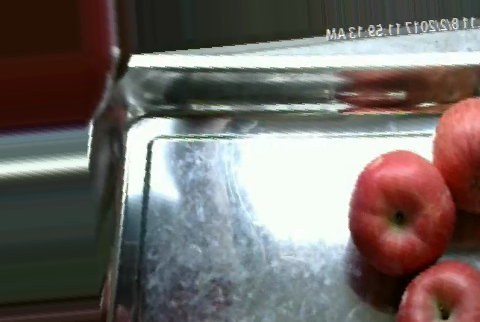

In [5]:
data_path = "{}/Initial_ingredients".format(os.getcwd())
item = "Apple"
n = 1753
PIL.Image.open("{path}/{item}/{item_cap} 0{n}.png".format(path = data_path, item = item, item_cap = item, n = n))

In [6]:
# Batch_size defines the number of samples that will be propagated through the network.
# https://stats.stackexchange.com/questions/153531/what-is-batch-size-in-neural-network
batch_size = 32
# The size to which the images will be resized when loaded
img_height = 256
img_width = 256

Now, we will use these parameters to load the data

In [7]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_path,
    labels = "inferred",
    validation_split = 0.2, # 20% of the data will be used for validation
    subset="training",
    color_mode = "rgb",
    seed = 1,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 31667 files belonging to 10 classes.
Using 25334 files for training.
Metal device set to: Apple M1


2022-09-21 14:00:54.522333: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-09-21 14:00:54.522816: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [8]:
train_ds.class_names

['Apple',
 'Banana',
 'Kiwi',
 'Mango',
 'Orange',
 'Peach',
 'Pear',
 'Plum',
 'Pomegranate',
 'Tomatoes']

And validation data

In [9]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_path,
  validation_split=0.2,
  subset="validation",
  seed=1,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 31667 files belonging to 10 classes.
Using 6333 files for validation.


Now we can have a look at the loaded data:

2022-09-21 14:01:07.352011: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


tf.Tensor([6 1 2 8 0 5 3 3 1 2 0 7 4 4 2 4 2 4 2 9 0 0 0 3 1 9 2 0 2 0 1 0], shape=(32,), dtype=int32)


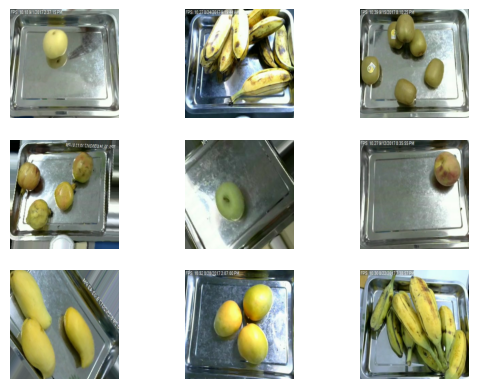

In [10]:
for images, labels in train_ds.take(1):
    print(labels)
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.axis("off")

The next step is to understand more about data caching:
- Dataset.cache keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache. See https://www.tensorflow.org/api_docs/python/tf/data/Dataset#cache
- Dataset.prefetch overlaps data preprocessing and model execution while training.
Now, we must combine both of these steps to 

In [11]:
# Cache the data

First, note the difference between normalization and scaling:

> Scaling just changes the range of your data. Normalization is a more radical transformation. The point of normalization is to change your observations so that they can be described as a normal distribution.

Next step is normalizing the data. 

In [27]:
# Test running the layers on different devices
def get_compiled_model():
    # Make a simple 2-layer densely-connected neural network.
    inputs = keras.Input(shape=(img_height, img_width, 3))
    with tf.device("/CPU:0"):
        x = layers.RandomContrast(factor=0.75)(inputs)
        x = layers.RandomRotation(factor=0.10)(x)
        x = layers.RandomTranslation(height_factor=0.2, width_factor=0.1)(x)
    with tf.device("/GPU:0"):
        outputs = keras.layers.Dense(1)(x)
    model = keras.Model(inputs, outputs)
    model.compile(
        loss=tf.keras.losses.mean_absolute_error,
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
        metrics=['mean_absolute_error', 'accuracy']
    )
    return model

model = get_compiled_model()

# Train the model on all available devices.
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=10
)

Epoch 1/10


2022-09-19 14:18:25.951020: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


 15/396 [>.............................] - ETA: 21:15 - loss: 22.5442 - mean_absolute_error: 22.5442 - accuracy: 0.1335

KeyboardInterrupt: 

Now, writing the model. I will test three types of models: one with a pretrained base and another with a smaller custom base

In [11]:
def get_compiled_model_mine():
    # Make a simple 2-layer densely-connected neural network.
    inputs = keras.Input(shape=(img_height, img_width, 3))
    with tf.device("/CPU:0"):
        x = layers.RandomContrast(factor=0.75)(inputs)
        x = layers.RandomRotation(factor=0.10)(x)
        x = layers.RandomTranslation(height_factor=0.2, width_factor=0.1)(x)
    with tf.device("/GPU:0"):
        x = layers.Rescaling(1./255, input_shape=(img_height, img_width, 3))(inputs)
        x = layers.Conv2D(16, 3, padding='same', activation='relu')(x)
        x = layers.MaxPooling2D()(x)
        
        x = layers.Conv2D(32, 3, padding='same', activation='relu')(x)
        x = layers.MaxPooling2D()(x)
        x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
        x = layers.MaxPooling2D()(x)
        
        x = layers.Flatten()(x)
        x = layers.Dense(128, activation='relu')(x)
        outputs = layers.Dense(10)(x)
    model = keras.Model(inputs, outputs)

    return model


model = get_compiled_model_mine()

# Sequential([
#     layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
#     layers.Conv2D(16, 3, padding='same', activation='relu'),
#     layers.MaxPooling2D(),
#     layers.Conv2D(32, 3, padding='same', activation='relu'),
#     layers.MaxPooling2D(),
#     layers.Conv2D(64, 3, padding='same', activation='relu'),
#     layers.MaxPooling2D(),
#     layers.Flatten(),
#     layers.Dense(128, activation='relu'),
#     layers.Dense(6)
# ])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=10
)

Epoch 1/10


2022-09-21 14:03:01.589265: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


792/792 [==============================] - ETA: 0s - loss: 0.4341 - accuracy: 0.8506

2022-09-21 14:05:07.619118: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


792/792 [==============================] - 137s 168ms/step - loss: 0.4341 - accuracy: 0.8506 - val_loss: 0.2373 - val_accuracy: 0.9209
Epoch 2/10
792/792 [==============================] - 121s 153ms/step - loss: 0.0987 - accuracy: 0.9651 - val_loss: 0.1033 - val_accuracy: 0.9645
Epoch 3/10
792/792 [==============================] - 123s 156ms/step - loss: 0.0618 - accuracy: 0.9784 - val_loss: 0.1240 - val_accuracy: 0.9591
Epoch 4/10
792/792 [==============================] - 122s 153ms/step - loss: 0.0375 - accuracy: 0.9873 - val_loss: 0.1883 - val_accuracy: 0.9490
Epoch 5/10
792/792 [==============================] - 121s 153ms/step - loss: 0.0539 - accuracy: 0.9836 - val_loss: 0.1661 - val_accuracy: 0.9520
Epoch 6/10
792/792 [==============================] - 122s 154ms/step - loss: 0.0219 - accuracy: 0.9926 - val_loss: 0.1717 - val_accuracy: 0.9534
Epoch 7/10
792/792 [==============================] - 123s 155ms/step - loss: 0.0228 - accuracy: 0.9938 - val_loss: 0.1768 - val_accura

There is significant overfitting which can be seen from differences in accuracy and val_accuracy. To be honest, I am not sure yet how to f

In [16]:
pretrained_base = tf.keras.applications.VGG16(
    include_top=False,
    input_shape=(img_height,img_width, 3),
    pooling="MAX"
)
pretrained_base.trainable = False

In [19]:
def model_pretrained_base():
    inputs = keras.Input(shape=(img_height, img_width, 3), batch_size = 500)
    with tf.device("/CPU:0"):
        x = layers.RandomContrast(factor=0.75)(inputs)
        x = layers.RandomRotation(factor=0.10)(x)
        x = layers.RandomTranslation(height_factor=0.2, width_factor=0.1)(x)
    with tf.device("/GPU:0"):
        x = pretrained_base(x)
        x = layers.Flatten()(x)
        x = layers.Dense(10, activation = "relu")(x)
        outputs = layers.Dense(10)(x)
    model = keras.Model(inputs, outputs)
    return model

model_pretrained = model_pretrained_base()

model_pretrained.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model_pretrained.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    verbose=1,
)

Epoch 1/10


2022-09-19 13:35:28.003770: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


KeyboardInterrupt: 

In [29]:

def smaller_base():
    inputs = keras.Input(shape=(img_height, img_width, 3))
    with tf.device("/CPU:0"):
        x = layers.RandomContrast(factor=0.75)(inputs)
        x = layers.RandomRotation(factor=0.10)(x)
        x = layers.RandomTranslation(height_factor=0.2, width_factor=0.1)(x)
    with tf.device("/GPU:0"):
    #First block
        x = layers.Rescaling(1./255, input_shape=(img_height, img_width, 3))(x)
        x = layers.Conv2D(filters=32, kernel_size=3, activation='relu', padding='same')(x)
        x = layers.MaxPooling2D()(x)

        #Second block
        x = layers.BatchNormalization(renorm=True)(x)
        x = layers.Conv2D(filters=64, kernel_size=3, activation='relu', padding='same')(x)
        x = layers.MaxPooling2D()(x)

        #Third block
        x = layers.BatchNormalization(renorm=True)(x)
        x = layers.Conv2D(filters=128, kernel_size=3, activation='relu', padding='same')(x)
        x = layers.Conv2D(filters=128, kernel_size=3, activation='relu', padding='same')(x)
        x = layers.MaxPooling2D()(x)

        #Head
        x = layers.Flatten()(x)
        x = layers.Dense(6, activation = "relu")(x)
        outputs = layers.Dense(6) (x)
        
        
    model = keras.Model(inputs, outputs)
    return model
    
model_smallerBase = smaller_base()


model_smallerBase.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model_smallerBase.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    verbose=1,
)

Epoch 1/10
14/14 [==============================] - 22s 1s/step - loss: 1.9692 - accuracy: 0.1810 - val_loss: 1.7915 - val_accuracy: 0.1714
Epoch 2/10
14/14 [==============================] - 22s 1s/step - loss: 1.7913 - accuracy: 0.1929 - val_loss: 1.7910 - val_accuracy: 0.1714
Epoch 3/10
14/14 [==============================] - 21s 1s/step - loss: 1.7904 - accuracy: 0.1929 - val_loss: 1.7905 - val_accuracy: 0.1714
Epoch 4/10
14/14 [==============================] - 22s 1s/step - loss: 1.7897 - accuracy: 0.1929 - val_loss: 1.7901 - val_accuracy: 0.1714
Epoch 5/10
14/14 [==============================] - 22s 1s/step - loss: 1.7889 - accuracy: 0.1929 - val_loss: 1.7895 - val_accuracy: 0.1714
Epoch 6/10
14/14 [==============================] - 25s 2s/step - loss: 1.7882 - accuracy: 0.1929 - val_loss: 1.7892 - val_accuracy: 0.1714
Epoch 7/10
14/14 [==============================] - 23s 2s/step - loss: 1.7876 - accuracy: 0.1929 - val_loss: 1.7888 - val_accuracy: 0.1714
Epoch 8/10
14/14 [==